In [1]:
import sys
import os
sys.path.insert(0, '/Users/lerinalaluf/Desktop/SIP_2021/kaepora/src')
os.chdir('/Users/lerinalaluf/Desktop/SIP_2021/kaepora/src')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import kaepora as kpora
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#spectra_querry = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN"]
spectra_querry = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -1 and phase <= 1 and ((dm15_source < 1.8) or (dm15_from_fits < 1.8))"]

In [5]:
spec_array = kpora.grab(spectra_querry[0], db_file = '../data/kaepora_v1_DEV.db')

170 Total Spectra found
170 spectra of SNe that have host reddening corrections
Arrays cleaned


In [17]:
def fluxGrid(spec_array):
    
    MINSTART = spec_array[0].x1
    MINEND = spec_array[0].x2

    for spec in spec_array:
        if spec.x1 < MINSTART:
            MINSTART = spec.x1
        if spec.x2 > MINEND:
            MINEND = spec.x2
    
    all_data = 0.0

    for spec in spec_array:
        all_data += len(spec.flux[~np.isnan(spec.flux)])
    
    length = len(spec_array[0].flux[~np.isnan(spec_array[0].flux)])

    for spec in spec_array:
        if length > len(spec.flux[~np.isnan(spec.flux)]):
            length = len(spec.flux[~np.isnan(spec.flux)])
    
    total_data = all_data
    data_percent = 0.0

    start = MINSTART

    bestStart = None
    bestLength = None

    while (start + length - 1 <= MINEND):
        total_data = all_data

        while (start + length - 1 <= MINEND):
            num_cols = len(spec_array)
            
            for spec in spec_array:
                array_start = spec.flux[:start]
                array_end = spec.flux[(start + length - 1):]
                new_array = spec.flux[start:(start + length)]

                total_data -= len(array_start[~np.isnan(array_start)])
                total_data -= len(array_end[~np.isnan(array_end)])

                if any(np.isnan(new_array)):
                    total_data -= len(new_array[~np.isnan(new_array)])
                    num_cols -= 1

            new_data = total_data/all_data

            if new_data > data_percent:
                data_percent = new_data
                bestStart = start
                bestLength = length
                best_num_cols = num_cols

            total_data = all_data
            start += 100

        start = MINSTART 
        length += 100
    
    MIN = bestStart
    MAX = bestStart + bestLength - 1

    num_rows = bestLength
    num_cols = best_num_cols
    
    grid = []
    k = 0
    
    while len(grid) < num_cols:
        if all(~np.isnan(spec_array[k].flux)[MIN:(MAX + 1)]):
            grid.append(spec_array[k].flux[MIN:(MAX + 1)])
        k += 1
    
    np.savetxt('../Flux_Grid', grid)
    
    MIN = spec_array[0].wavelength[MIN]
    MAX = spec_array[0].wavelength[MAX]
    
    print (MIN, MAX)
    return (MIN, MAX)

In [18]:
MIN, MAX = fluxGrid(spec_array)


(3854.0, 7142.0)


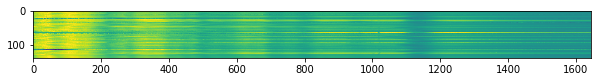

In [19]:
data = np.loadtxt('../Flux_Grid')

plt.figure(figsize=[10,10])
plt.imshow(data)